In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, accuracy_score
warnings.filterwarnings('ignore')

%matplotlib inline

In [35]:
df = pd.read_csv("./data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [36]:
df.shape

(284807, 31)

In [37]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

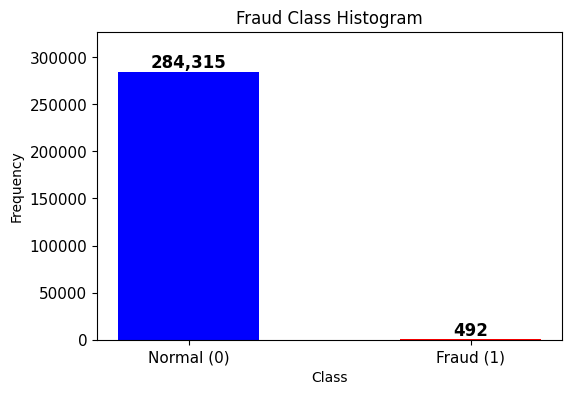

In [38]:
count_classes = df['Class'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(count_classes.index, count_classes.values, color=['blue', 'red'], width=0.5)

plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 200, f"{int(height):,}", 
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
    
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'], fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, max(count_classes) * 1.15)

plt.show()

In [39]:
scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [40]:
X = df.drop(['Class'], axis=1)
y = df['Class']

In [41]:
number_records_fraud = y.sum()
print(f"Number of fraud transactions: {number_records_fraud}")

Number of fraud transactions: 492


In [42]:
fraud_indices = df[df['Class'] == 1].index
normal_indices = df[df['Class'] == 0].index

In [43]:
num_samples = min(len(normal_indices), number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, num_samples, replace=False)

In [44]:
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.loc[under_sample_indices]

In [45]:
X_undersample = under_sample_data.drop(columns=['Class'])
y_undersample = under_sample_data['Class']

In [46]:
fraud_percentage = (y_undersample.sum() / len(y_undersample)) * 100
print(f"Percentage of normal transactions: {100 - fraud_percentage:.2f}%")
print(f"Percentage of fraud transactions: {fraud_percentage:.2f}%")
print(f"Total transactions in undersampled data: {len(under_sample_data)}")

Percentage of normal transactions: 50.00%
Percentage of fraud transactions: 50.00%
Total transactions in undersampled data: 984


In [47]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(
    X_undersample, y_undersample, test_size=0.3, random_state=42, stratify=y_undersample
)
print(f"Train set (undersampled): {len(X_train_undersample)} samples")
print(f"Test set (undersampled): {len(X_test_undersample)} samples")

Train set (undersampled): 688 samples
Test set (undersampled): 296 samples


In [48]:
def printing_Kfold_scores(x_train_data, y_train_data):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    best_c = None
    best_score = 0

    for c_param in c_param_range:
        print(f"\nC Parameter: {c_param}\n" + "-" * 40)
        recall_scores = []

        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(x_train_data), start=1):
            lr = LogisticRegression(C=c_param, penalty='l1', solver='liblinear')
            lr.fit(x_train_data.iloc[train_idx], y_train_data.iloc[train_idx])

            y_pred = lr.predict(x_train_data.iloc[test_idx])
            recall = recall_score(y_train_data.iloc[test_idx], y_pred)
            recall_scores.append(recall)

            print(f"Iteration {fold_idx}: Recall Score = {recall:.4f}")

        mean_recall = np.mean(recall_scores)
        print(f"\nMean Recall Score: {mean_recall:.4f}\n")

        if mean_recall > best_score:
            best_score = mean_recall
            best_c = c_param

    print("\n" + "*" * 50)
    print(f"Best model from cross-validation has C parameter = {best_c}")
    print("*" * 50)

    return best_c

In [49]:
best_c = printing_Kfold_scores(X_train_undersample, y_train_undersample)


C Parameter: 0.01
----------------------------------------
Iteration 1: Recall Score = 0.9552
Iteration 2: Recall Score = 0.9844
Iteration 3: Recall Score = 0.9600
Iteration 4: Recall Score = 0.9706
Iteration 5: Recall Score = 1.0000

Mean Recall Score: 0.9740


C Parameter: 0.1
----------------------------------------
Iteration 1: Recall Score = 0.9104
Iteration 2: Recall Score = 0.8906
Iteration 3: Recall Score = 0.9333
Iteration 4: Recall Score = 0.8382
Iteration 5: Recall Score = 0.8857

Mean Recall Score: 0.8917


C Parameter: 1
----------------------------------------
Iteration 1: Recall Score = 0.9104
Iteration 2: Recall Score = 0.9219
Iteration 3: Recall Score = 0.9600
Iteration 4: Recall Score = 0.8529
Iteration 5: Recall Score = 0.9143

Mean Recall Score: 0.9119


C Parameter: 10
----------------------------------------
Iteration 1: Recall Score = 0.9104
Iteration 2: Recall Score = 0.9375
Iteration 3: Recall Score = 0.9467
Iteration 4: Recall Score = 0.8529
Iteration 5: Reca

In [50]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [51]:
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [52]:
y_pred_undersample = lr.predict(X_test_undersample)

Recall Metric on Test Dataset: 0.9459


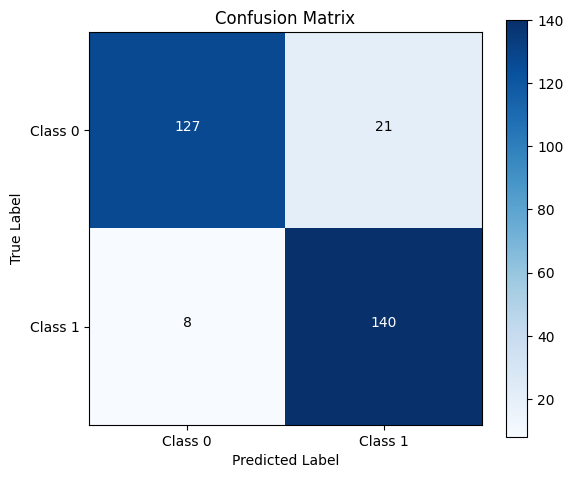

In [53]:
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
recall = recall_score(y_test_undersample, y_pred_undersample)
print(f"Recall Metric on Test Dataset: {recall:.4f}")

plot_confusion_matrix(cnf_matrix, classes=["Class 0", "Class 1"], title='Confusion Matrix')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [55]:
lr = LogisticRegression(C=best_c, penalty='l1', solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

In [56]:
y_pred = lr.predict(X_test)

In [57]:
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

Recall: 0.5405


In [58]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [59]:
lr_resampled = LogisticRegression(C=best_c, penalty='l1', solver='liblinear', random_state=42)
lr_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = lr_resampled.predict(X_test)
recall_resampled = recall_score(y_test, y_pred_resampled)
print(f"Recall Metric after SMOTE: {recall_resampled:.4f}")

Recall Metric after SMOTE: 0.8378


In [60]:
precision = precision_score(y_test, y_pred_resampled)
print(f"Precision: {precision:.4f}")

Precision: 0.2279


In [61]:
y_scores = lr_resampled.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

Optimal Threshold: 4.0387


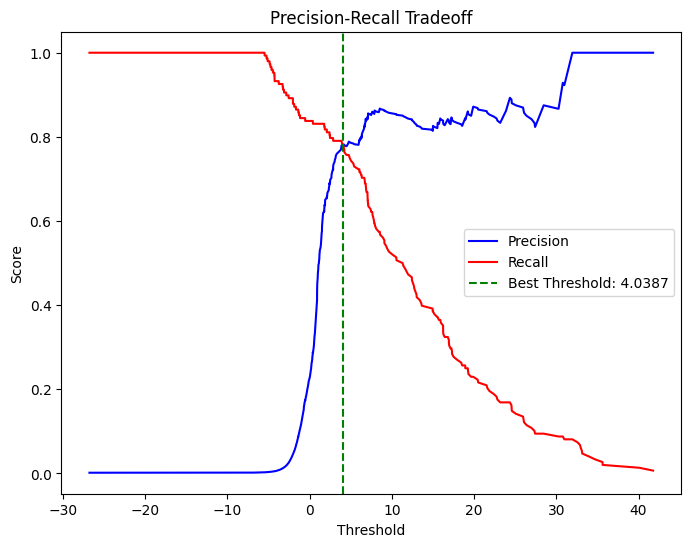

In [62]:
closest_index = np.argmin(np.abs(precision - recall))
best_threshold = thresholds[closest_index]

print(f"Optimal Threshold: {best_threshold:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='red')
plt.axvline(x=best_threshold, color='green', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.show()

In [63]:
y_pred_final = (y_scores >= best_threshold).astype(int)

In [64]:
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"Final Precision: {precision_final:.4f}")
print(f"Final Recall: {recall_final:.4f}")
print(f"Final Accuracy: {accuracy_final:.4f}")

Final Precision: 0.7770
Final Recall: 0.7770
Final Accuracy: 0.9992


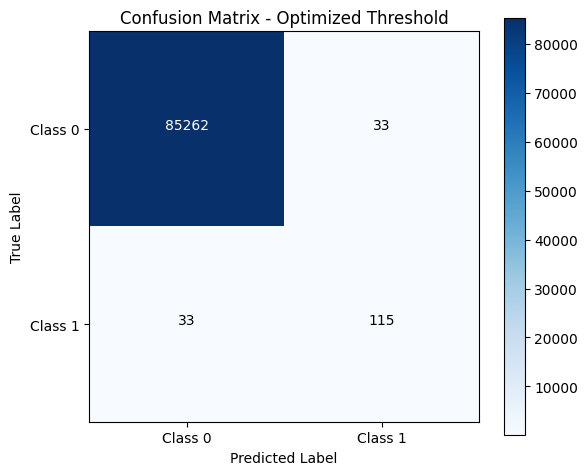

In [65]:
cnf_matrix_final = confusion_matrix(y_test, y_pred_final)
plot_confusion_matrix(cnf_matrix_final, classes=["Class 0", "Class 1"], title='Confusion Matrix - Optimized Threshold')

In [66]:
model_data = {
    "model": lr_resampled,
    "threshold": best_threshold
}

joblib.dump(model_data, "fraud_detection.pkl")

['fraud_detection.pkl']